# This notebook provides brief examples on how to use the matched filter (MF) and constrained matched filter (CMF) functions that are provided in the flat-sky approximation as part of the pyMF module. The latter is a new extension of the matched filter concept that is introduced in Erler et al. (2018) (arXiv:). In this notebook we use simulations of the thermal Sunyaev-Zeldovich effect signal and CMB mock data. 

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
from astropy.io import fits
from ipywidgets import FloatProgress
from IPython.display import display

h = 6.626070040e-34 #Planck constant (J*s)
k_B = 1.38064852e-23 #Botzmann constant (J/K)
T_CMB = 2.7255 #CMB monopole temperature (K)

In [2]:
#Import pyMF
import pymf as mf

We start by creating the mock data that will be used for the demonstrations. The cmb mock data is stored in the /examples sub-directory and was generated using CAMB (Lewis et al. 2000) assuming a generic flat $\Lambda$CDM cosmology with $\Omega_\Lambda = 0.7$, $\Omega_m = 0.3$ and $h = 0.7$. Galaxy clusters are simulated using a projected $\beta$-model (Cavaliere & Fusco-Femiano 1976). The default model parameters are a core radius $r_c = 2$ arcmin, $\beta=1$ and a central Comptonization parameter $y_0=10^{-4}$. The simulated maps have a size of 4° by 4° and a pixel size of 0.4 arcmin, both of which are fixed by the provided CMB mock data. The default resolution of the data is 2 arcmin, but we encourage the user to change the value of the resolution, $r_c$, $y_0$, and map noise to develop an understanding how these parameters affect the matched filters. Throughout this notebook we use units of $K_\mathrm{CMB}$.

In [3]:
#Define properties of the mock data
freq = 150e9
fwhm_arcmin = 2 #arcmin
sigma_noise = 6.4e-6 #noise level (K-arcmin)

#Define cluster model properties
y_0 = 1e-4 #Central Comptonization parameter (model  amplitude)
r_c = 2 #Core radius
beta = 1

#Load CMB mock data and define map dimensions
#The map size and pixel size are determined by the CMB mock data and should not be changed.

hdulist=fits.open("example_maps/cmb_mocks.fits")
cmb = hdulist[0].data
hdulist.close()
n_maps = cmb.shape[0] #number of maps

pixel_size = 0.4 #arcmin/pixel
map_size = 4 #degrees
npix = int(map_size*60 / pixel_size) 

# create cluster model (using beta-model)

YY, XX = np.indices((npix, npix))
center = (npix//2,npix//2)
r = np.sqrt((XX-center[0])**2 + (YY-center[1])**2)*pixel_size

cluster = y_0 * (1+(r/r_c)**2)**((1-3*beta)/2)

#create source template (cluster template normalized to unity and smoothed with beam)
source = cluster/y_0

sigma_beam = fwhm_arcmin / (2*np.sqrt(2*np.log(2))) / pixel_size
source = gaussian_filter(source, sigma=sigma_beam, order=0, mode='wrap', truncate=20.0)

#Compute tSZ spectrum

x = h*freq / k_B / T_CMB
spec = (x*(np.exp(x)+1)/(np.exp(x)-1) - 4)*T_CMB

#create point source template for CMF examples
A_point = 1e-4
point_source = np.exp(-0.5*(r/(sigma_beam*pixel_size))**2)

In the next step, we combine the simulated cluster with a single mock CMB image and add noise. The mock data is then filtered with a matched filter

$\Psi = \left[\tau^\mathrm{T} C^{-1} \tau \right]^{-1} \tau C^{-1}$

where $\tau$ is the Fourier transform of the source template that was convolved with the beam and $C$ is the power spectrum of the map. The function mf.filter_map_mf() therefore requires two inputs, the first being the (mock) observation, while the second is the convolved source template. In its default mode, the function will compute the power spectrum directly from the provided data, however optional variables allows to provide either a separate noise map or the standard deviation of the noise in case it is Gaussian. The filter function returns three variables, the filtered map, the 2D filter window, and the noise of the filtered map

$\sigma = \left[\Psi^\mathrm{T} C \Psi \right]^\frac{1}{2}$.

In [4]:
#convolve mock data with beam
data = gaussian_filter(spec*cluster+cmb[0,:,:], sigma=sigma_beam, order=0, mode='wrap', truncate=20.0)
#create and add white noise
noise = np.random.randn(npix,npix)*(sigma_noise/pixel_size)
data += noise

#filter data with matched filter
mf_map, mf_filter, mf_noise = mf.filter_map_mf(data, source)

The central deconvolved cluster tSZ signal is then given by the map value at the position of the center of the cluster.

In [5]:
print("tSZ signal: ", '{:0.2e}'.format(mf_map[center]), "K_CMB")
print("noise: ", '{:0.2e}'.format(mf_noise), "K_CMB")
print("SNR: ", '{:0.2f}'.format(mf_map[center]/mf_noise))

tSZ signal:  -2.46e-04 K_CMB
noise:  2.36e-05 K_CMB
SNR:  -10.44


The two plots below show the mock data and the filtered map. The latter has been converted from $T_\mathrm{SZ}$ to $y_0$.

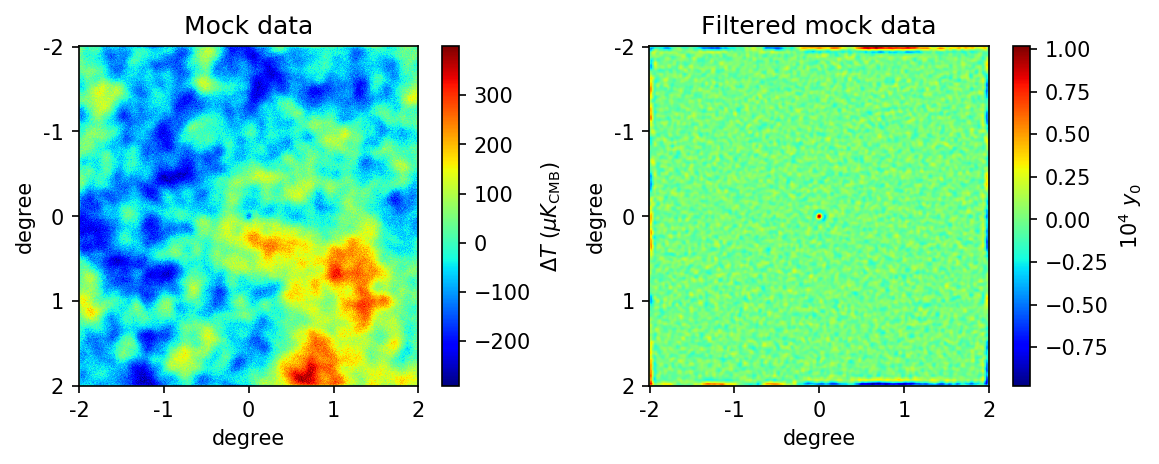

In [6]:
fig = plt.figure(figsize=(9,3), dpi=150)

plt.subplot(1,2,1)
plt.imshow(1e6*data, cmap = "jet")
plt.title("Mock data")
plt.xlabel("degree")
plt.ylabel("degree")
plt.xticks([0,150,300,450,600],[-2,-1,0,1,2])
plt.yticks([0,150,300,450,600],[-2,-1,0,1,2])
plt.colorbar(label = r"$\Delta T$ ($\mu K_\mathrm{CMB}$)")

plt.subplot(1,2,2)

plt.imshow(1e4*mf_map/spec, cmap = "jet")
plt.title("Filtered mock data")
plt.xlabel("degree")
plt.ylabel("degree")
plt.xticks([0,150,300,450,600],[-2,-1,0,1,2])
plt.yticks([0,150,300,450,600],[-2,-1,0,1,2])
plt.colorbar(label = r"$10^4 \ y_0$")

The next figures show the 1D profiles of the filter window and filter kernel.

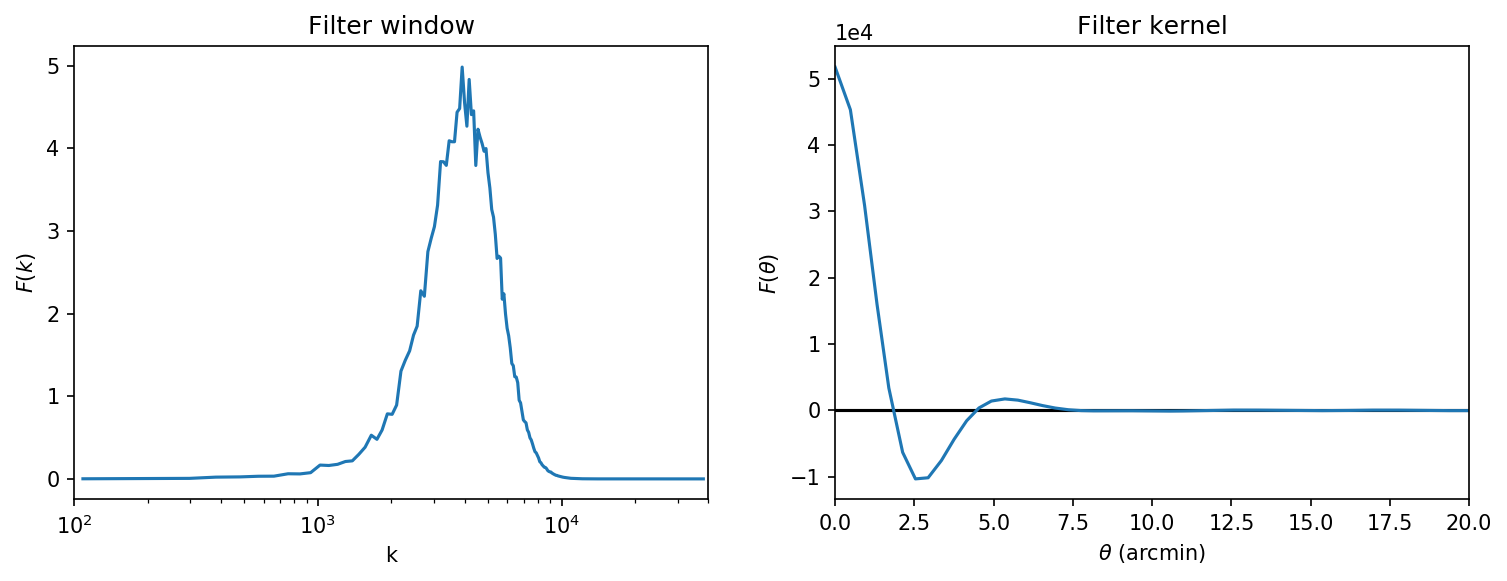

In [7]:
#Compute filter kernel through Fourier transform of the filter window
mf_kernel = np.real(np.fft.ifft2(np.fft.ifftshift(mf_filter))) * npix**2

#Compute radial profiles of window and kernel. 
#The spatial frequency k has been computed using a conversion that allows a direct 
#comparison with the spherical multipole moment ell.
k, window = mf.rad_profile(abs(mf_filter), pixel_size, return_k=True)
theta, kernel = mf.rad_profile(mf_kernel, pixel_size, return_k=False)

fig = plt.figure(figsize=(12,4), dpi=150)

plt.subplot(1,2,1)
plt.semilogx(k, window)
plt.xlim(1e2,4e4)
plt.title("Filter window")
plt.xlabel(r"k")
plt.ylabel(r"$F(k)$")

plt.subplot(1,2,2)
plt.plot([0,170],[0,0], '-', color="black")
plt.plot(theta*pixel_size, kernel)
plt.xlim(0,20)
plt.title("Filter kernel")
plt.xlabel(r"$\theta$ (arcmin)")
plt.ylabel(r"$F(\theta)$")
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

Finally, we demonstrate that the filtered maps are indeed unbiased. For this we process 100 mock observations and plot the recovered tSZ signal.

In [8]:
#This part of the code will create 100 mock-observations and filter the data

results = np.zeros((2,n_maps))

#initailize progress bar (optional)
f = FloatProgress(min=0, max=n_maps)
display(f)

for i in np.arange(n_maps):

    #convolve mock data with beam
    data = gaussian_filter(spec*cluster+cmb[i,:,:], sigma=sigma_beam, order=0, mode='wrap', truncate=20.0)
    #create and add white noise
    noise = np.random.randn(npix,npix)*(sigma_noise/pixel_size)
    data += noise

    #filter data with matched filter
    mf_map, mf_filter, mf_noise = mf.filter_map_mf(data, source)
    results[:,i] = [mf_map[center], mf_noise]

    #increase value of progress bar (optional)
    f.value += 1

A Jupyter Widget

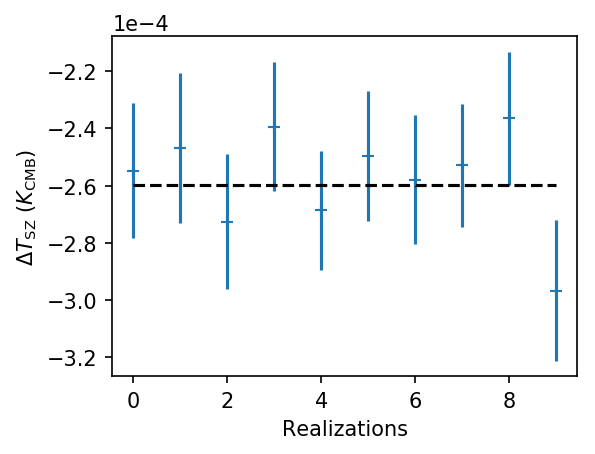

In [9]:
#visualize results

fig = plt.figure(figsize=(4,3), dpi=150)

plt.errorbar(np.arange(n_maps), results[0,:], yerr = results[1,:], fmt="+")
plt.plot([0,n_maps-1],[y_0*spec,y_0*spec], '--', color="black")
plt.xlabel("Realizations")
plt.ylabel(r"$\Delta T_\mathrm{SZ} \ (K_\mathrm{CMB})$")

plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

# Now follows the same examples but including a central point source for the cluster and using the constrained single-frequency matched filter

We repeat the previous examples and combine the simulated cluster with a single mock CMB image and add noise. In addition, we now add a central point source to the cluster to demonstrate the application of the constrained matched filter:

$\Psi = e^\mathrm{T} \left[T^\mathrm{T} C^{-1} T \right]^{-1} T C^{-1}$,

where $T$ is a matrix that contains the Fourier transform of the source templates that were convolved with the beam, $e$ is the response of the filter to the templates, and $C$ is the power spectrum of the map. The function mf.filter_map_cmf() requires three inputs, the first being the (mock) observation, the second is a data cube that contains the convolved source templates, and the third an array that contains the filter responses. As before, in its default mode the function computes the power spectrum directly from the provided data. The same optional variables as for the standard matched filter allow to provide either a separate noise map or the standard deviation of the noise in case it is Gaussian. The filter function returns three variables, the filtered map, the 2D filter window, and the noise of the filtered map

$\sigma = \left[\Psi^\mathrm{T} C \Psi \right]^\frac{1}{2}$.

In [10]:
#convolve mock data with beam
data = gaussian_filter(spec*cluster+cmb[0,:,:], sigma=sigma_beam, order=0, mode='wrap', truncate=20.0)
#add central point source
data += A_point*point_source
#create and add white noise
data += np.random.randn(npix,npix)*(sigma_noise/pixel_size)

#combine source templates into one array
templates = np.array([source, point_source])

#define filter response
response = np.array([1,0])

#filter data with matched filter
mf_map, mf_filter, mf_noise = mf.filter_map_mf(data, source)
#filter data with constrained matched filter
cmf_map, cmf_filter, cmf_noise = mf.filter_map_cmf(data, templates, response)

In [11]:
print("MF tSZ signal: ", '{:0.2e}'.format(mf_map[center]), "K_CMB")
print("MF noise: ", '{:0.2e}'.format(mf_noise), "K_CMB")
print("MF SNR: ", '{:0.2f}'.format(mf_map[center]/mf_noise))
print("")
print("CMF tSZ signal: ", '{:06.2e}'.format(cmf_map[center]), "K_CMB")
print("CMF noise: ", '{:0.2e}'.format(cmf_noise), "K_CMB")
print("CMF SNR: ", '{:0.2f}'.format(cmf_map[center]/cmf_noise))
print("")
print("sigma_CMF/sigma_MF: ", '{:0.2f}'.format(cmf_noise/mf_noise))

MF tSZ signal:  -4.99e-05 K_CMB
MF noise:  2.33e-05 K_CMB
MF SNR:  -2.15

CMF tSZ signal:  -2.47e-04 K_CMB
CMF noise:  3.22e-05 K_CMB
CMF SNR:  -7.69

sigma_CMF/sigma_MF:  1.38


The three plots below show the mock data and the filtered maps. The latter two have been converted from $T_\mathrm{SZ}$ to $y_0$.

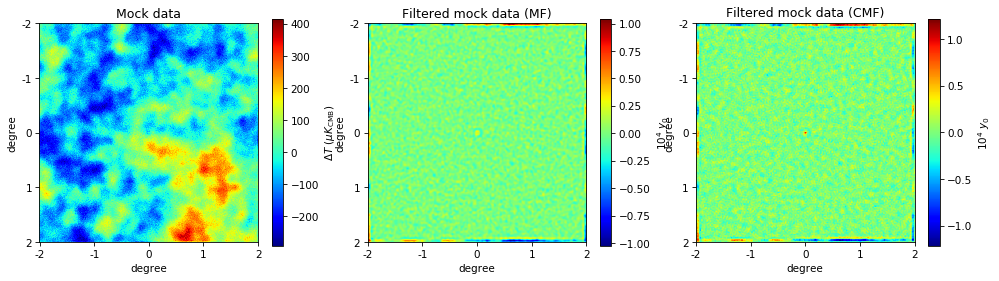

In [12]:
fig = plt.figure(figsize=(16,4), dpi=75)

plt.subplot(1,3,1)
plt.imshow(1e6*data, cmap = "jet")
plt.title("Mock data")
plt.xlabel("degree")
plt.ylabel("degree")
plt.xticks([0,150,300,450,600],[-2,-1,0,1,2])
plt.yticks([0,150,300,450,600],[-2,-1,0,1,2])
plt.colorbar(label = r"$\Delta T$ ($\mu K_\mathrm{CMB}$)")

plt.subplot(1,3,2)

plt.imshow(1e4*mf_map/spec, cmap = "jet")
plt.title("Filtered mock data (MF)")
plt.xlabel("degree")
plt.ylabel("degree")
plt.xticks([0,150,300,450,600],[-2,-1,0,1,2])
plt.yticks([0,150,300,450,600],[-2,-1,0,1,2])
plt.colorbar(label = r"$10^4 \ y_0$")

plt.subplot(1,3,3)

plt.imshow(1e4*cmf_map/spec, cmap = "jet")
plt.title("Filtered mock data (CMF)")
plt.xlabel("degree")
plt.ylabel("degree")
plt.xticks([0,150,300,450,600],[-2,-1,0,1,2])
plt.yticks([0,150,300,450,600],[-2,-1,0,1,2])
plt.colorbar(label = r"$10^4 \ y_0$")

The next figures show the 1D profiles of the filter windows and filter kernels.

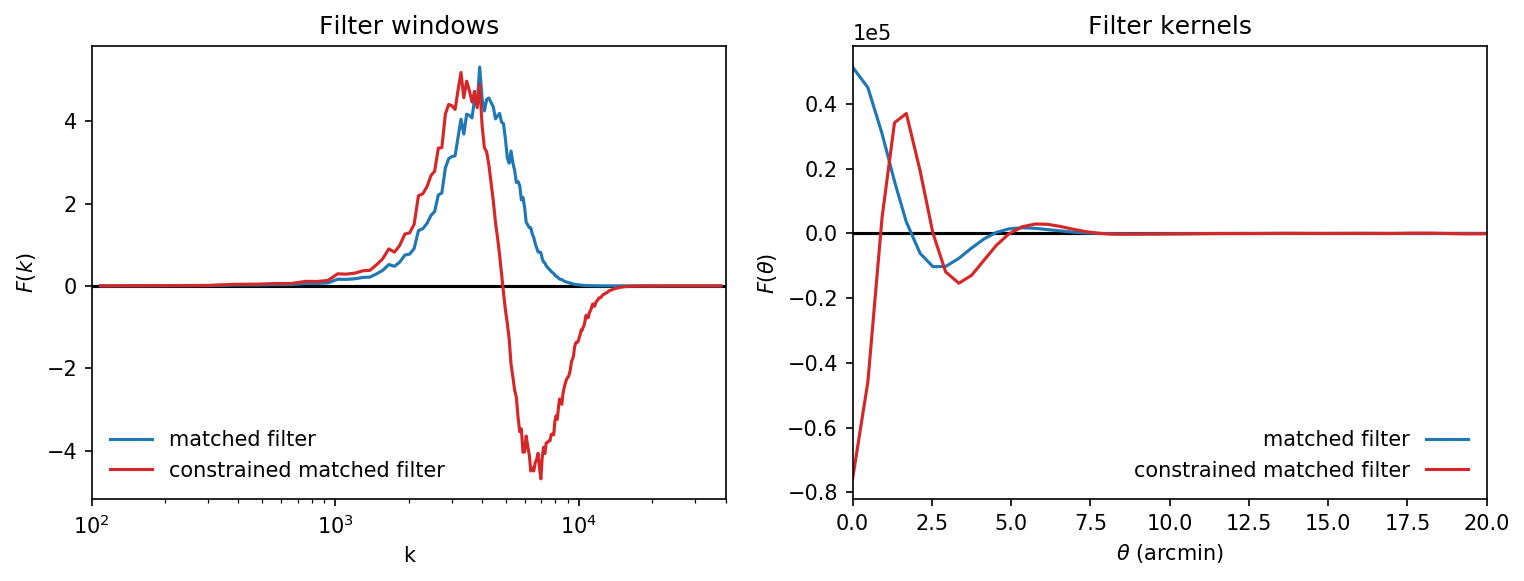

In [13]:
#Compute filter kernel through Fourier transform of the filter window
mf_kernel = np.real(np.fft.ifft2(np.fft.ifftshift(mf_filter))) * npix**2
cmf_kernel = np.fft.ifftshift(np.real(np.fft.ifft2(np.fft.ifftshift(cmf_filter)))) * npix**2


#Compute radial profiles of window and kernel. 
#The spatial frequency k has been computed using a conversion that allows a direct 
#comparison with the spherical multipole moment ell.
k, mf_window = mf.rad_profile(abs(mf_filter), pixel_size, return_k=True)
k, cmf_window = mf.rad_profile(np.real(cmf_filter), pixel_size, return_k=True)
theta, mf_kernel = mf.rad_profile(mf_kernel, pixel_size, return_k=False)
theta, cmf_kernel = mf.rad_profile(cmf_kernel, pixel_size, return_k=False)


fig = plt.figure(figsize=(12,4), dpi=150)

plt.subplot(1,2,1)
plt.plot([1e2,4e4],[0,0], '-', color="black")
plt.semilogx(k, mf_window, label="matched filter")
plt.semilogx(k, cmf_window, color = "C3", label="constrained matched filter")
plt.xlim(1e2,4e4)
plt.title("Filter windows")
plt.xlabel(r"k")
plt.ylabel(r"$F(k)$")
plt.legend(frameon=False, loc="lower left", markerfirst=True)

plt.subplot(1,2,2)
plt.plot([0,170],[0,0], '-', color="black")
plt.plot(theta*pixel_size, mf_kernel, label="matched filter")
plt.plot(theta*pixel_size, cmf_kernel, color = "C3", label="constrained matched filter")
plt.xlim(0,20)
plt.title("Filter kernels")
plt.xlabel(r"$\theta$ (arcmin)")
plt.ylabel(r"$F(\theta)$")
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.legend(frameon=False, loc="lower right", markerfirst=False)

Finally, we demonstrate that the central point source induces a bias in the matched filtered map, while the constrained matched filtered map is unbiased. For this we process 100 mock observations and plot the recovered tSZ signal.

In [14]:
#This part of the code will create 100 mock-observations and filter the data

results = np.zeros((4,n_maps))

#initailize progress bar (optional)
f = FloatProgress(min=0, max=n_maps)
display(f)

for i in np.arange(n_maps):

    #convolve mock data with beam
    data = gaussian_filter(spec*cluster+cmb[i,:,:], sigma=sigma_beam, order=0, mode='wrap', truncate=20.0)
    #add central point source
    data += A_point*point_source
    #create and add white noise
    data += np.random.randn(npix,npix)*(sigma_noise/pixel_size)

    #filter data with matched filter
    mf_map, mf_filter, mf_noise = mf.filter_map_mf(data, source)
    #filter data with constrained matched filter
    cmf_map, cmf_filter, cmf_noise = mf.filter_map_cmf(data, templates, response)
    results[:,i] = [mf_map[center], mf_noise, cmf_map[center], cmf_noise]

    #increase value of progress bar (optional)
    f.value += 1

A Jupyter Widget

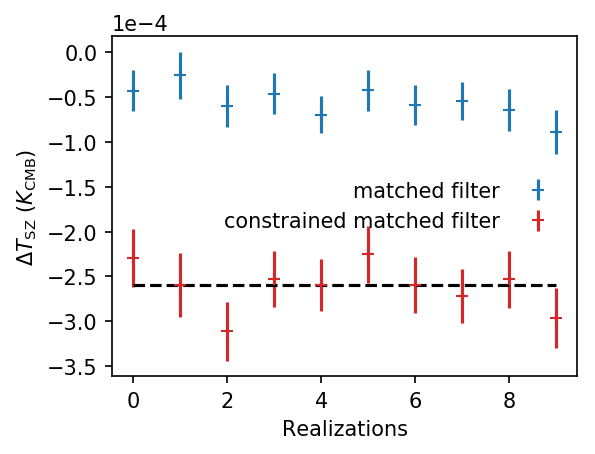

In [15]:
#visualize results

fig = plt.figure(figsize=(4,3), dpi=150)

plt.errorbar(np.arange(n_maps), results[0,:], yerr = results[1,:], fmt="+", label="matched filter")
plt.errorbar(np.arange(n_maps), results[2,:], yerr = results[3,:], fmt="+", color="C3", label="constrained matched filter")
plt.plot([0,n_maps-1],[y_0*spec,y_0*spec], '--', color="black")
plt.xlabel("Realizations")
plt.ylabel(r"$\Delta T_\mathrm{SZ} \ (K_\mathrm{CMB})$")
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.legend(frameon=False, loc="center right", markerfirst=False)